<a href="https://colab.research.google.com/github/SunDubey/DeepLearning/blob/main/fashion_mnist_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



In [ ]:
#Import important libraries
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate,add
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add ,Flatten ,Dense
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Read csv data files
train_data = pd.read_csv('./fashion-mnist_train.csv')
test_data = pd.read_csv('./fashion-mnist_test.csv')

In [ ]:
train_data.shape #(60,000*785)
test_data.shape #(10000,785)
train_X= np.array(train_data.iloc[:,1:])
test_X= np.array(test_data.iloc[:,1:])
train_Y= np.array (train_data.iloc[:,0]) # (60000,)
test_Y = np.array(test_data.iloc[:,0]) #(10000,)

In [ ]:
# Convert the images into 3 channels to fit in input for transfer models
train_X=np.dstack([train_X] * 3)
test_X=np.dstack([test_X]*3)
train_X.shape,test_X.shape

((60000, 784, 3), (10000, 784, 3))

In [ ]:
# Reshape images as per the tensor format required by tensorflow
train_X = train_X.reshape(-1, 28,28,3)
test_X= test_X.reshape (-1,28,28,3)
train_X.shape,test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [ ]:
# Resize the images 48*48 as required by transfer learning 
from keras.preprocessing.image import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])
train_X.shape, test_X.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [ ]:
#specify Labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

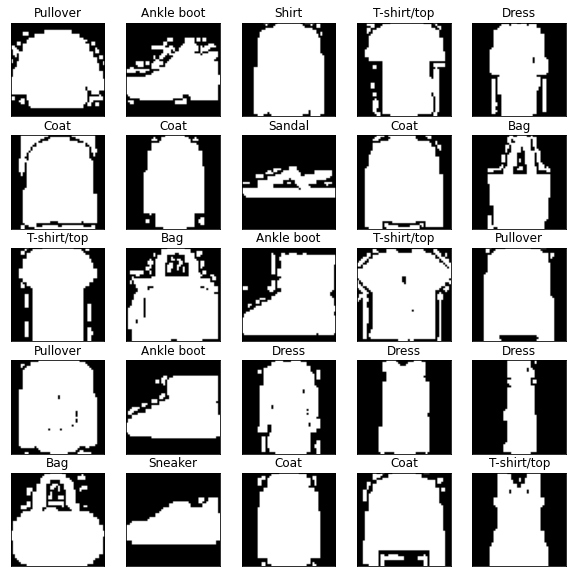

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.title(class_names[train_Y[i]])
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])    
    plt.imshow(train_X[i])
plt.show()


In [ ]:
# Normalize the data and change data type
train_X = train_X / 255.
test_X = test_X / 255.

In [ ]:
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

In [ ]:
train_X,valid_X,train_label,valid_label = train_test_split(train_X,
                                                           train_Y_one_hot,
                                                           test_size=0.05,
                                                           random_state=13
                                                           )

In [ ]:
imageSize=train_X[0].shape[0]
Channels=3
print("imageSize : ",imageSize)

imageSize :  48


In [ ]:
# VGG-16
from tensorflow.keras.applications.vgg16  import VGG16
preTrainedModelVgg16 = VGG16(input_shape = (imageSize, imageSize, Channels), 
                                include_top = False, 
                                weights=None)
preTrainedModelVgg16.load_weights("./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")
VGG16layers=preTrainedModelVgg16.layers
print("Number of layer Vgg16 : ",len(VGG16layers))

Number of layer Vgg16 :  19


In [ ]:
for layer  in range(len(VGG16layers)-5): 
       VGG16layers[layer].trainable = False 
        
preTrainedModelVgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [ ]:
#Vgg16 Model
x=Flatten()(preTrainedModelVgg16.output)

#Fully Connection Layer

# FC1
x=Dense(1024, activation="relu")(x)

# FC2
x=Dense(1024, activation="relu")(x)

# FC3
x=Dense(1024, activation="relu")(x)

#Dropout to avoid overfitting effect
x=Dropout(0.5)(x)

# FC4
x=Dense(512, activation="relu")(x)

# FC5
x=Dense(512, activation="relu")(x)

#Dropout to avoid overfitting effect
x=Dropout(0.4)(x)

# FC6
x=Dense(256, activation="relu")(x)

# FC7
x=Dense(64, activation="relu")(x)

# FC8
x=Dense(64, activation="relu")(x)

#Dropout to avoid overfitting effect
x=Dropout(0.2)(x)

#output layer
x=Dense(10,activation="softmax")(x)

In [ ]:
#concatenation layers
modelVgg16=Model(preTrainedModelVgg16.input,x)
modelVgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [ ]:
#RMSPorp Optimization
optRMSProp=tf.keras.optimizers.RMSprop(
    learning_rate=0.0001,
    momentum=0.0001,
    epsilon=1e-07,
    name="RMSprop",
)

In [ ]:
#compile Vgg16 Model
modelVgg16.compile(optimizer=optRMSProp, loss="categorical_crossentropy",metrics=['accuracy'])

In [ ]:
#Hyperparameters 
Epochs=10
BatchSize=700

In [ ]:
#fit Vgg16 Model
historyVgg16Model=modelVgg16.fit(train_X,train_label,validation_data=(valid_X,valid_label) ,epochs=Epochs 
                                                    , batch_size =BatchSize   ,verbose=1)

Epoch 1/10
82/82 [==============================] - 1917s 23s/step - loss: 1.7747 - accuracy: 0.3228 - val_loss: 0.6631 - val_accuracy: 0.7790
Epoch 2/10
82/82 [==============================] - 1924s 23s/step - loss: 0.6978 - accuracy: 0.7646 - val_loss: 0.5615 - val_accuracy: 0.8057
Epoch 3/10
82/82 [==============================] - 1921s 23s/step - loss: 0.5087 - accuracy: 0.8321 - val_loss: 0.4488 - val_accuracy: 0.8473
Epoch 4/10
82/82 [==============================] - 1901s 23s/step - loss: 0.4265 - accuracy: 0.8602 - val_loss: 0.4018 - val_accuracy: 0.8630
Epoch 5/10
82/82 [==============================] - 1911s 23s/step - loss: 0.3808 - accuracy: 0.8748 - val_loss: 0.3335 - val_accuracy: 0.8867
Epoch 6/10
82/82 [==============================] - 1921s 23s/step - loss: 0.3294 - accuracy: 0.8917 - val_loss: 0.3073 - val_accuracy: 0.8903
Epoch 7/10
82/82 [==============================] - 1910s 23s/step - loss: 0.3067 - accuracy: 0.8974 - val_loss: 0.2808 - val_accuracy: 0.9063

In [ ]:
modelVgg16.save("WeightsForVgg16.h5")
print("Done for Vgg16")

Done for Vgg16


- the Accuracy and Loss for Vgg16 Model With 100 Epochs


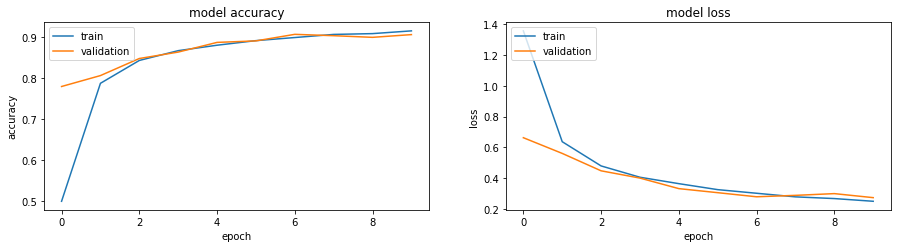

In [ ]:
#Vgg16 Model

print("- the Accuracy and Loss for Vgg16 Model With 100 Epochs")

plt.figure(figsize=(40,20))
# summarize history for accuracy
plt.subplot(5,5,1)
plt.plot(historyVgg16Model.history['accuracy'])
plt.plot(historyVgg16Model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')


# summarize history for loss
plt.subplot(5,5,2)
plt.plot(historyVgg16Model.history['loss'])
plt.plot(historyVgg16Model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()